# Modelo 3

### modelo de IA para prever série temporal

- Importando as bibliotecas

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit as MonteCarlo

- Carregando o dataset

In [15]:
df = pd.read_csv('DailyDelhiClimateTrain.csv')
df_test = pd.read_csv('DailyDelhiClimateTest.csv')
df.info(), df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1462 non-null   object 
 1   meantemp      1462 non-null   float64
 2   humidity      1462 non-null   float64
 3   wind_speed    1462 non-null   float64
 4   meanpressure  1462 non-null   float64
dtypes: float64(4), object(1)
memory usage: 57.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          114 non-null    object 
 1   meantemp      114 non-null    float64
 2   humidity      114 non-null    float64
 3   wind_speed    114 non-null    float64
 4   meanpressure  114 non-null    float64
dtypes: float64(4), object(1)
memory usage: 4.6+ KB


(None, None)

- Definindo as datas como indice

In [16]:
df['date'] = pd.to_datetime(df['date'])#, format='%d.%m.%Y %H:%M:%S')
df = df.set_index('date')

df_test['date'] = pd.to_datetime(df_test['date'])#, format='%d.%m.%Y %H:%M:%S')
df_test = df_test.set_index('date')

In [17]:
df.columns

Index(['meantemp', 'humidity', 'wind_speed', 'meanpressure'], dtype='object')

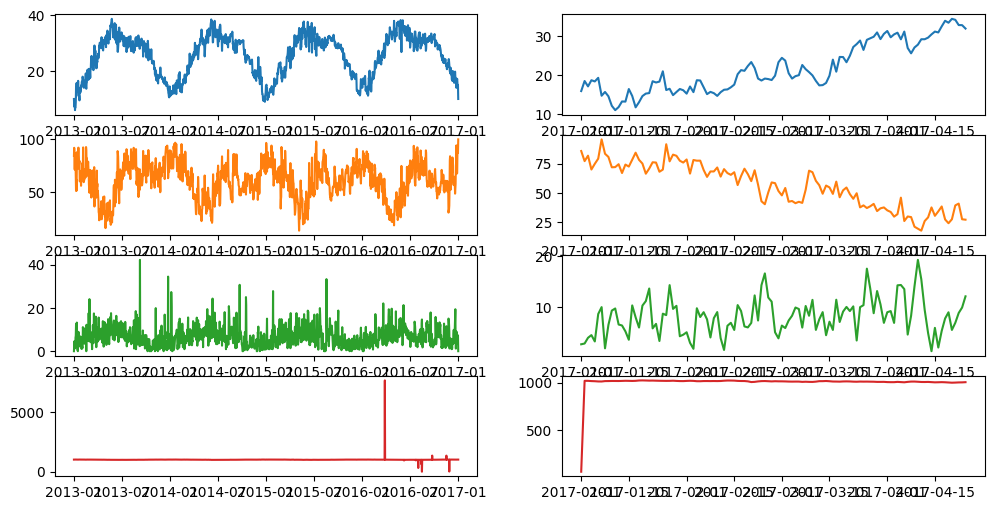

In [33]:
fig, ax = plt.subplots(len(df.columns),2,figsize=(12, 6))

for i,col in enumerate(df.columns):
    ax[i,0].plot(df[col],color=plt.cm.tab10(i))
    ax[i,1].plot(df_test[col],color=plt.cm.tab10(i))


- É perceptível a presença de outliers para a pressão média

{'whiskers': [<matplotlib.lines.Line2D at 0x7f63fbcef730>,
 'caps': [<matplotlib.lines.Line2D at 0x7f63fbcefc70>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f63fbcef490>],
 'medians': [<matplotlib.lines.Line2D at 0x7f63fbd20220>],
 'fliers': [],
 'means': []}

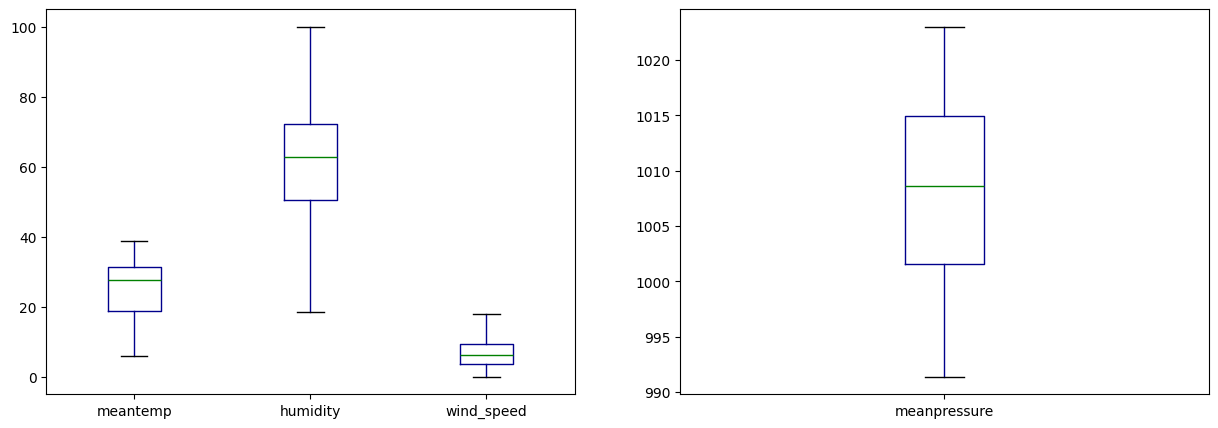

In [19]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
cl1 = df[list(df.columns)[:-1]]
cl2 = df[list(df.columns)[-1:]]
#plt.boxplot(cl1,)
ax1.boxplot(cl1,
    boxprops=dict(color='darkblue'),
    capprops=dict(color='black'),
    whiskerprops=dict(color='darkblue'),
    flierprops=dict(color='cyan', markeredgecolor='yellow'),
    medianprops=dict(color='green'),
labels=cl1.columns,showfliers=False)

ax2.boxplot(cl2,
    boxprops=dict(color='darkblue'),
    capprops=dict(color='black'),
    whiskerprops=dict(color='darkblue'),
    flierprops=dict(color='cyan', markeredgecolor='yellow'),
    medianprops=dict(color='green'),
labels=cl2.columns,showfliers=False)
#ax1.boxplot(df[list(df.columns)[:-1]],showfliers=False)
#ax2.boxplot(df[list(df.columns)[-1]],showfliers=False)

#df[list(df.columns)[:-1]].boxplot(showfliers=False)

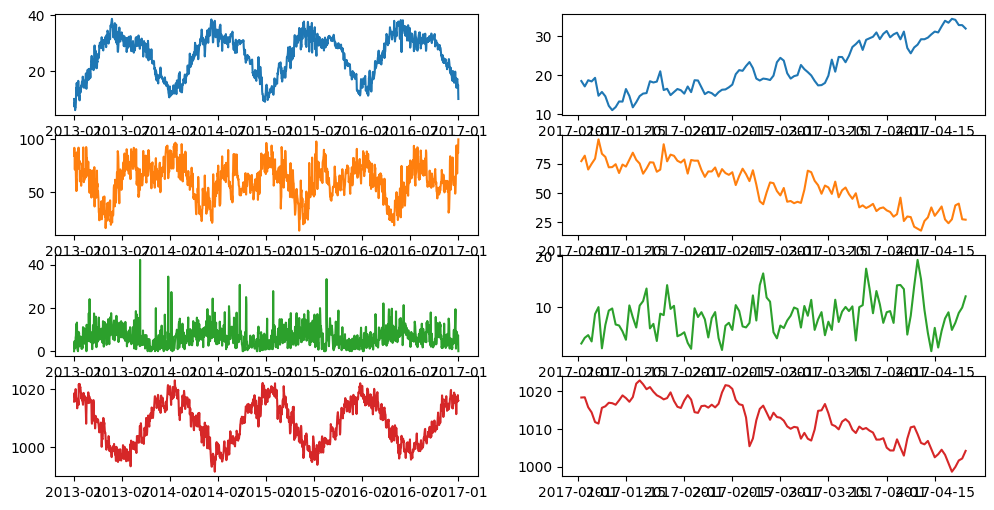

In [34]:
filters = []

for i, iter_df in enumerate([df,df_test]):
    Q1 = iter_df['meanpressure'].quantile(0.25)
    Q3 = iter_df['meanpressure'].quantile(0.75)
    IQR = Q3 - Q1
    filter = (iter_df['meanpressure'] >= Q1 - 1.5 * IQR) & (iter_df['meanpressure'] <= Q3 + 1.5 *IQR)
    filters.append(filter)
    sml1 = iter_df.loc[filter]
    #sml1.plot(subplots=True)

fig, ax = plt.subplots(len(df.columns),2,figsize=(12, 6))

for i,col in enumerate(df.columns):
    ax[i,0].plot(df.loc[filters[0]][col],color=plt.cm.tab10(i))
    ax[i,1].plot(df_test.loc[filters[1]][col],color=plt.cm.tab10(i))

In [21]:
cl1 = np.abs(stats.zscore(df.meanpressure))
cl1

date
2013-01-01    0.025321
2013-01-02    0.037162
2013-01-03    0.041972
2013-01-04    0.033647
2013-01-05    0.029946
                ...   
2016-12-28    0.024758
2016-12-29    0.032193
2016-12-30    0.037743
2016-12-31    0.027726
2017-01-01    0.027171
Name: meanpressure, Length: 1462, dtype: float64

array([<Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>], dtype=object)

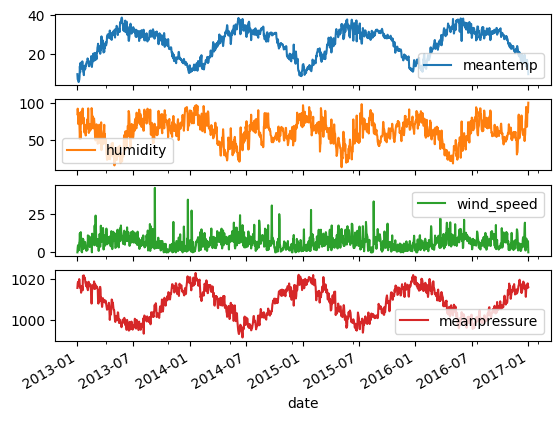

In [22]:
sml2 = df[
    #(np.abs(stats.zscore(df)) < 3).all(axis=1)
    (np.abs(stats.zscore(df.meanpressure)) < 0.359)
]
sml2.plot(subplots=True)

In [23]:
diff_size1 = pd.concat([sml1,sml2]).drop_duplicates(keep=False)
if diff_size1.__len__() == 0:
    print("nenhuma diferença no corte dos outliers em meantemperature")
else:
    print(diff_size1)

nenhuma diferença no corte dos outliers em meantemperature


- Função para gerar as séries de predição

In [24]:
def create_features_labels(df, cols, window_size=7):
    X, y = [], []
    for i in range(len(df) - window_size):
        X.append(df[cols].iloc[i:i+window_size].values.flatten())
        y.append(df[cols].iloc[i+window_size].values.flatten())
    return np.array(X), np.array(y)

- As variáveis de entrada são alocadas num vetor

In [35]:
windows_size  = 7


X_train, y_train = create_features_labels(df.loc[filters[0]],df.columns, window_size=windows_size)
X_test, y_test = create_features_labels(df_test.loc[filters[1]], df_test.columns, window_size=windows_size)
X_train[0], y_train[0]


(array([  10.        ,   84.5       ,    0.        , 1015.66666667,
           7.4       ,   92.        ,    2.98      , 1017.8       ,
           7.16666667,   87.        ,    4.63333333, 1018.66666667,
           8.66666667,   71.33333333,    1.23333333, 1017.16666667,
           6.        ,   86.83333333,    3.7       , 1016.5       ,
           7.        ,   82.8       ,    1.48      , 1018.        ,
           7.        ,   78.6       ,    6.3       , 1020.        ]),
 array([   8.85714286,   63.71428571,    7.14285714, 1018.71428571]))

**RANDOM FOREST**

In [38]:
model = RandomForestRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f'r²(total):{r2_score(y_test,y_pred)}')

for i in range(4):
    print(f'r²({df.columns[i]}) = {r2_score(y_test[:,i], y_pred[:,i]):.3f}')
    

r²(total):0.6294928427593298
r²(meantemp) = 0.868
r²(humidity) = 0.827
r²(wind_speed) = -0.012
r²(meanpressure) = 0.835


- GridSearch

In [40]:
param_grid= {
    'bootstrap': [True, False],
    'max_depth': [5, 10, 15,  20, None],
    'max_features': ['sqrt','log2',1.0],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [200, 400, 600, 800, 1000]
}

monteCarlo = MonteCarlo(n_splits=10, test_size=0.7)
gridSearch = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=monteCarlo,
    scoring='r2',
    n_jobs=-1
)

gridSearch.fit(X_train,y_train)

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=None, test_size=0.7, train_size=None),
             estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [5, 10, 15, 20, None],
                         'max_features': ['sqrt', 'log2', 1.0],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [200, 400, 600, 800, 1000]},
             scoring='r2')

In [41]:
gridSearch.best_estimator_

RandomForestRegressor(min_samples_leaf=2, n_estimators=1000)

In [43]:
best_estimator = dict(min_samples_leaf=2, n_estimators=1000)

model = RandomForestRegressor(**best_estimator)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f'r²(total):{r2_score(y_test,y_pred):.3f}')

for i in range(4):
    print(f'r²({df.columns[i]}) = {r2_score(y_test[:,i], y_pred[:,i]):.3f}')
    

r²(total):0.634
r²(meantemp) = 0.873
r²(humidity) = 0.828
r²(wind_speed) = -0.008
r²(meanpressure) = 0.844
